# Markerless Pose Tracking

This lab develops convolutional neural networks (CNNs) for pose tracking in behavioral videos. The model is inspired by [DeepLabCut](http://www.mackenziemathislab.org/deeplabcut) (DLC), a popular tool for estimating keypoint locations from raw image data by leveraging features of pretrained neural networks for image classification.

We'll start with a simpler approach and build a CNN that frames pose tracking as a logistic regression problem. We convolve the input image with a template for each keypoint to get log-odds, and then pass them through the logistic function to get probabilities of the keypoints being present at each pixel.

The simple model forms a baseline for our deep neural network. We'll download a pretrained resnet50 and re-route an intermediate layer to obtain features for pose tracking. We'll skip some of the bells and whistles of DLC and just train a simple linear classifier on top of these features. As you'll see, the simple CNN makes for a pretty strong baseline. We'll see if we can eek out some improvement with the resnet!

## Setup

In [1]:
%%capture
try:
    import jaxtyping
except ImportError:
    !pip install jaxtyping

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms.functional
import torch.optim as optim
import warnings

from copy import deepcopy
from jaxtyping import Float, Int, Bool
from matplotlib.gridspec import GridSpec
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from tqdm.auto import trange
from typing import Optional, Any, Dict, Union, Tuple, List, Callable

# Helper function to convert between numpy arrays and tensors
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32
to_t = lambda array: torch.tensor(array, device=device, dtype=dtype)
from_t = lambda tensor: tensor.to("cpu").detach().numpy()

# Helper to round integer to odd number
to_odd = lambda x: int(np.ceil(x) // 2 * 2 + 1)

### Load the data

The dataset was downloaded from the [DeepLabCut github repo](https://github.com/DeepLabCut/DeepLabCut/) and lightly preprocessed with [this notebook](https://colab.research.google.com/drive/1-1MTX16Azx-lYr4ivzxxWwQvJXs4YKrM?usp=sharing).


In [3]:
!wget -nc https://github.com/slinderman/ml4nd/raw/refs/heads/main/data/03_pose_tracking/lab3_data.pt

--2025-04-23 05:23:20--  https://github.com/slinderman/ml4nd/raw/refs/heads/main/data/03_pose_tracking/lab3_data.pt
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/slinderman/ml4nd/refs/heads/main/data/03_pose_tracking/lab3_data.pt [following]
--2025-04-23 05:23:20--  https://media.githubusercontent.com/media/slinderman/ml4nd/refs/heads/main/data/03_pose_tracking/lab3_data.pt
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 712328325 (679M) [application/octet-stream]
Saving to: ‘lab3_data.pt’

lab3_data.pt        100%[===================>] 679.33M  76.4MB/s    in 7.4s    

2025-04

In [4]:
data = torch.load("lab3_data.pt")
train_images = data["train_images"]
train_coords = data["train_coords"]
train_targets = data["train_targets"]
val_images = data["val_images"]
val_coords = data["val_coords"]
val_targets = data["val_targets"]
test_images = data["test_images"]
keypoint_names = data["keypoint_names"]
num_keypoints = len(keypoint_names)

### Helper functions

In [5]:
#@title
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import base64

# Set some plotting defaults
sns.set_context("talk")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

def gradient_cmap(colors: List,
                  nsteps: int = 256,
                  bounds: Optional[np.ndarray] = None):
    # Make a colormap that interpolates between a set of colors
    ncolors = len(colors)
    if bounds is None:
        bounds = np.linspace(0,1,ncolors)

    reds = []
    greens = []
    blues = []
    alphas = []
    for b,c in zip(bounds, colors):
        reds.append((b, c[0], c[0]))
        greens.append((b, c[1], c[1]))
        blues.append((b, c[2], c[2]))
        alphas.append((b, c[3], c[3]) if len(c) == 4 else (b, 1., 1.))

    cdict = {'red': tuple(reds),
             'green': tuple(greens),
             'blue': tuple(blues),
             'alpha': tuple(alphas)}

    cmap = LinearSegmentedColormap('grad_colormap', cdict, nsteps)
    return cmap

cmaps = [
    gradient_cmap([np.array([1, 1, 1, 0]),
                   np.concatenate([color, [1]])])
    for color in palette
]


_VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def _anim_to_html(anim: animation.Animation,
                  fps: int = 20):
    # todo: todocument
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=fps, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video)

    return _VIDEO_TAG.format(anim._encoded_video.decode('ascii'))

def _display_animation(anim: animation.Animation,
                       fps: int = 30,
                       start: int = 0,
                       stop: Optional[int] = None):
    plt.close(anim._fig)
    return HTML(_anim_to_html(anim, fps=fps))

def play(movie: Int[Tensor, "num_frames height width 3"],
         fps: int = 30,
         speedup: int = 1,
         fig_height: int = 6,
         show_time: bool = False):

    # First set up the figure, the axis, and the plot element we want to animate
    T, Py, Px = movie.shape[:3]
    fig, ax = plt.subplots(1, 1, figsize=(fig_height * Px/Py, fig_height))
    im = plt.imshow(movie[0], interpolation='None', cmap=plt.cm.gray)

    if show_time:
        tx = plt.text(0.75, 0.05, 't={:.3f}s'.format(0),
                    color='white',
                    fontdict=dict(size=12),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform=ax.transAxes)
    plt.axis('off')

    def animate(i):
        im.set_data(movie[i * speedup])
        if show_time:
            tx.set_text("t={:.3f}s".format(i * speedup / fps))
        return im,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate,
                                   frames=T // speedup,
                                   interval=1,
                                   blit=True)
    plt.close(anim._fig)

    # return an HTML video snippet
    print("Preparing animation. This may take a minute...")
    return HTML(_anim_to_html(anim, fps=30))

#@title Helper functions to play movies with overlays { display-mode: "form" }
def play_overlay(movie: Int[Tensor, "num_frames height width 3"],
                 probs: Float[Tensor, "num_frames num_keypoints height width"],
                 fps: int = 30,
                 speedup: int = 1,
                 fig_height: int = 6,
                 show_time: bool = False,
                 prob_clip: float = 0.1):

    # First set up the figure, the axis, and the plot element we want to animate
    T, Py, Px = movie.shape[:3]
    assert probs.shape[0] == T
    num_keypoints = probs.shape[1]

    fig, ax = plt.subplots(1, 1, figsize=(fig_height * Px/Py, fig_height))
    im = plt.imshow(movie[0], interpolation='None', cmap=plt.cm.gray)

    p_ims = []
    for k, (name, color, cmap) in enumerate(zip(keypoint_names, palette, cmaps)):
        p_ims.append(plt.imshow(probs[0, k],
                     extent=(0, Px, Py, 0),
                     cmap=cmap, vmin=0, vmax=prob_clip))


    plt.axis('off')

    def animate(i):
        im.set_data(movie[i * speedup])
        for k, p_im in enumerate(p_ims):
            p_im.set_data(probs[i * speedup, k])
        return [im] + p_ims

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate,
                                   frames=T // speedup,
                                   interval=1,
                                   blit=True)
    plt.close(anim._fig)

    # return an HTML video snippet
    print("Preparing animation. This may take a minute...")
    return HTML(_anim_to_html(anim, fps=30))

def plot_example(image: Int[Tensor, "height width 3"],
                 coords: Float[Tensor, "num_keypoints 2"],
                 targets: Bool[Tensor, "num_keypoints height width"],
                 title: Optional[str] = None,
                 downsample: int = 1,
                 dilation: int = 1,
                 panel_size: int = 5,
                 plot_grid: bool = False):

    from scipy.ndimage import binary_dilation
    figsize = (panel_size * (num_keypoints + 1), panel_size)
    fig, axs = plt.subplots(1, 1 + num_keypoints, figsize=figsize)

    if image.ndim == 2:
        axs[0].imshow(image, cmap="Greys_r")
    elif image.ndim == 3:
        axs[0].imshow(image)
    else:
        raise Exception("image must be 2d grayscale or 3d rgb")
    for k in range(num_keypoints):
        axs[0].plot(coords[k, 0] / downsample,
                    coords[k, 1] / downsample,
                    marker='o', color=palette[k], ls='none',
                    label=keypoint_names[k])

    axs[0].legend(loc="lower right", fontsize=8)
    axs[0].set_axis_off()
    if title: axs[0].set_title(title)

    for k, target in enumerate(targets):
        axs[k + 1].imshow(binary_dilation(target, np.ones((dilation, dilation))))
        if plot_grid:
            height, width = target.shape
            axs[k + 1].hlines(-0.5 + np.arange(height + 1), -0.5, width, 'w', lw=0.5)
            axs[k + 1].vlines(-0.5 + np.arange(width + 1), -0.5, height, 'w', lw=0.5)
        axs[k + 1].set_title("Target: {}".format(keypoint_names[k]))
        axs[k + 1].set_axis_off()

def plot_image_and_probs(image: Int[Tensor, "height width 3"],
                         probs: Float[Tensor, "num_keypoints height width"],
                         probs_max: float = 1.0,
                         panel_size: int = 4):
    # Plot the image, the predictions for each keypoint, and a colorbar
    num_keypoints = probs.shape[0]
    if image.ndim == 3: image = image.mean(0)

    figsize = (panel_size * (1 + num_keypoints + .1), panel_size)
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(nrows=1, ncols=1 + num_keypoints + 1, figure=fig,
                  width_ratios=[1] * (1 + num_keypoints) + [0.1],)

    # Plot the (grayscale) image
    ax = plt.subplot(gs[0])
    ax.imshow(image, cmap="Greys_r")
    ax.axis('off')
    ax.set_title("input image $X$")

    # Plot the probabilities for each keypoint
    for k in range(num_keypoints):
        ax = plt.subplot(gs[k + 1])
        im = ax.imshow(probs[k], vmin=0, vmax=probs_max)
        ax.axis('off')
        ax.set_title("{} probs".format(keypoint_names[k]))

    # Plot a colorbar
    cbax = plt.subplot(gs[-1])
    plt.colorbar(im, cax=cbax)
    plt.tight_layout()

def plot_model_weights(basic_model: nn.Module,
                       panel_size: int = 4):
    weights = basic_model.final_conv.weight
    num_keypoints = weights.shape[0]
    vlim = from_t(abs(weights).max())

    figsize = (panel_size * (num_keypoints + .1), panel_size)
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(nrows=1, ncols=num_keypoints + 1, figure=fig,
                  width_ratios=[1] * (num_keypoints) + [0.1])

    for k in range(num_keypoints):
        ax = plt.subplot(gs[k])
        im = ax.imshow(from_t(weights[k, 0]), vmin=-vlim, vmax=vlim, cmap="RdBu")
        ax.set_title("weights: {}".format(keypoint_names[k]))
        ax.set_axis_off()

    cbax = plt.subplot(gs[-1])
    plt.colorbar(im, cax=cbax)

    plt.tight_layout()


### Plot a few training examples

Each example consists of an image and a set of binary masks, one for each keypoint. To create the masks, we first made a one-hot matrix with a 1 at the position of the keypoint. Then we performed a [binary dilation](https://en.wikipedia.org/wiki/Dilation_(morphology)#Binary_dilation) to make that target and make it visible in these plots. We'll do the same thing when we train the models below: a larger target offers some room for error in the pose tracking models and makes them easier to train.

Notice a few things:
- The training examples are not all the same size. Some are cropped and zoomed. This should help the model generalize to new test data.
- Some examples are missing a few keypoints. For example, the tongue isn't present in all frames.
- Since the training examples are different sizes, we'll have to be a bit careful during training. In particular, we'll use a batch size of 1 since it's not so straightforward to pack the training examples into a tensor. (instead, `type(train_images) == list`)

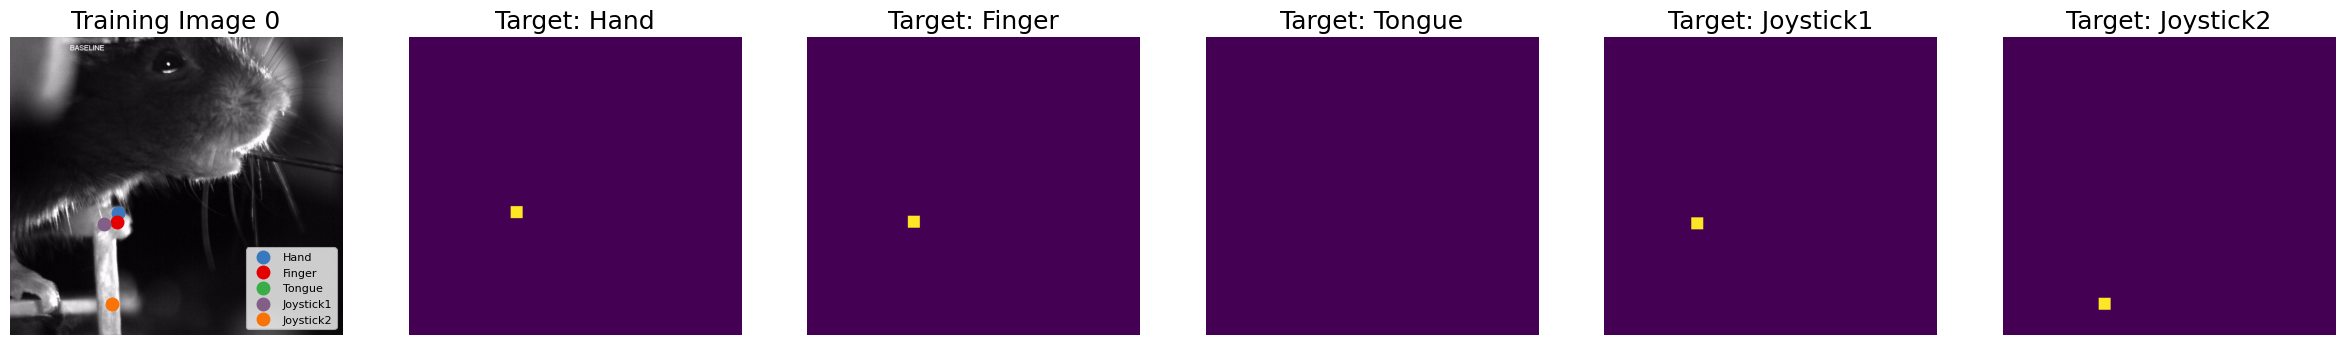

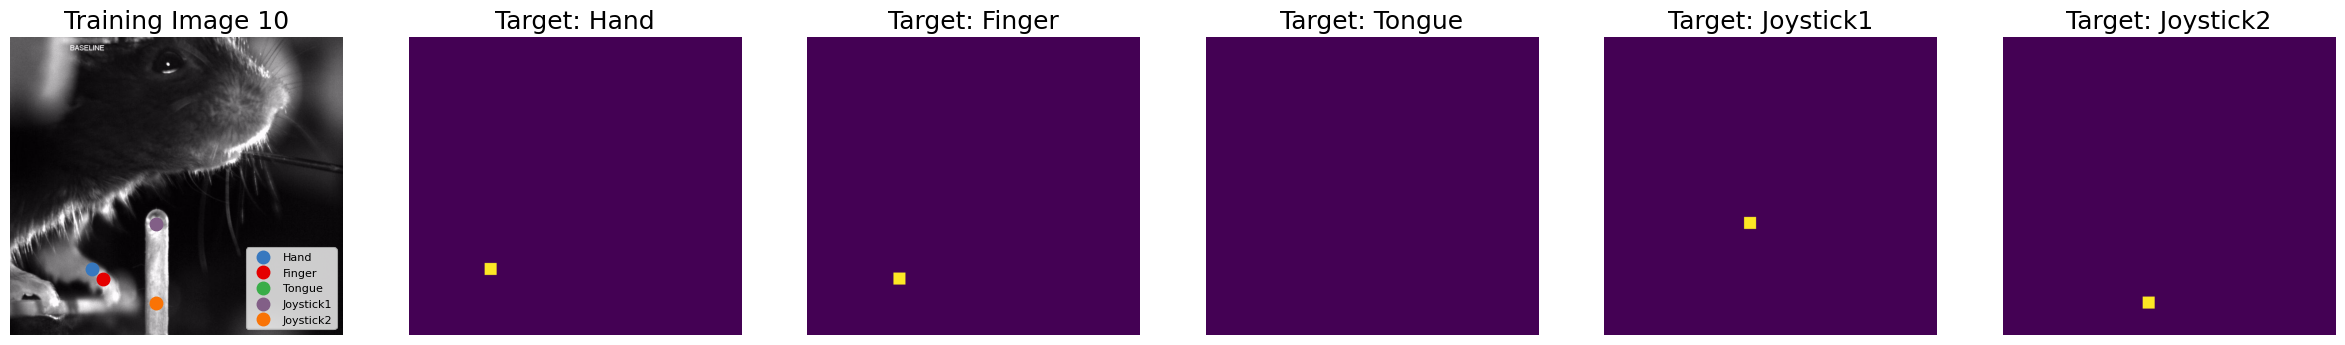

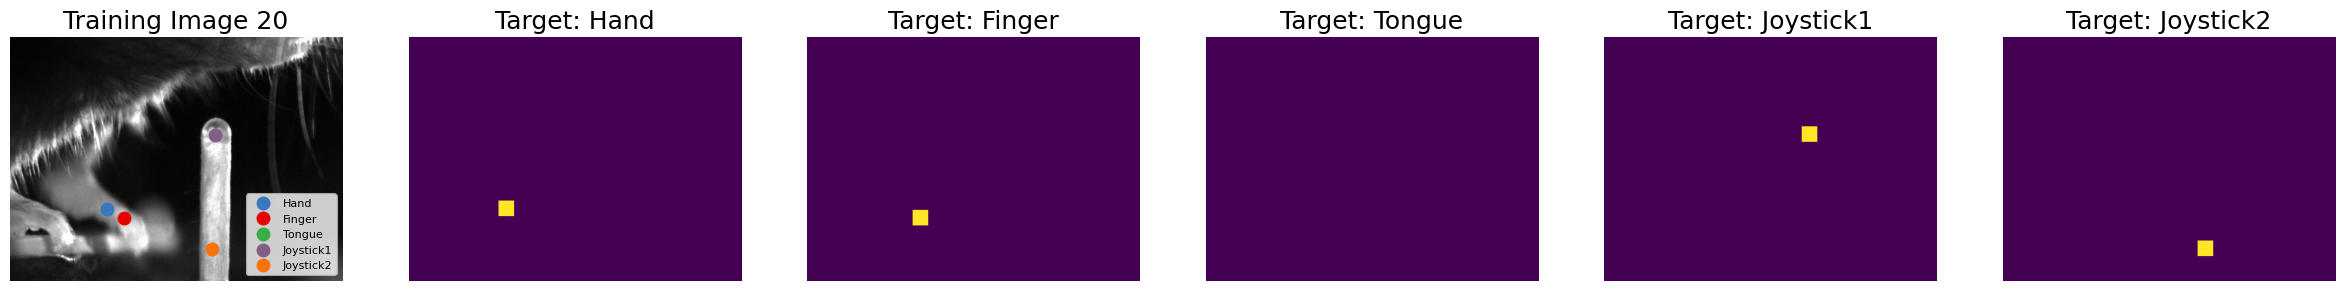

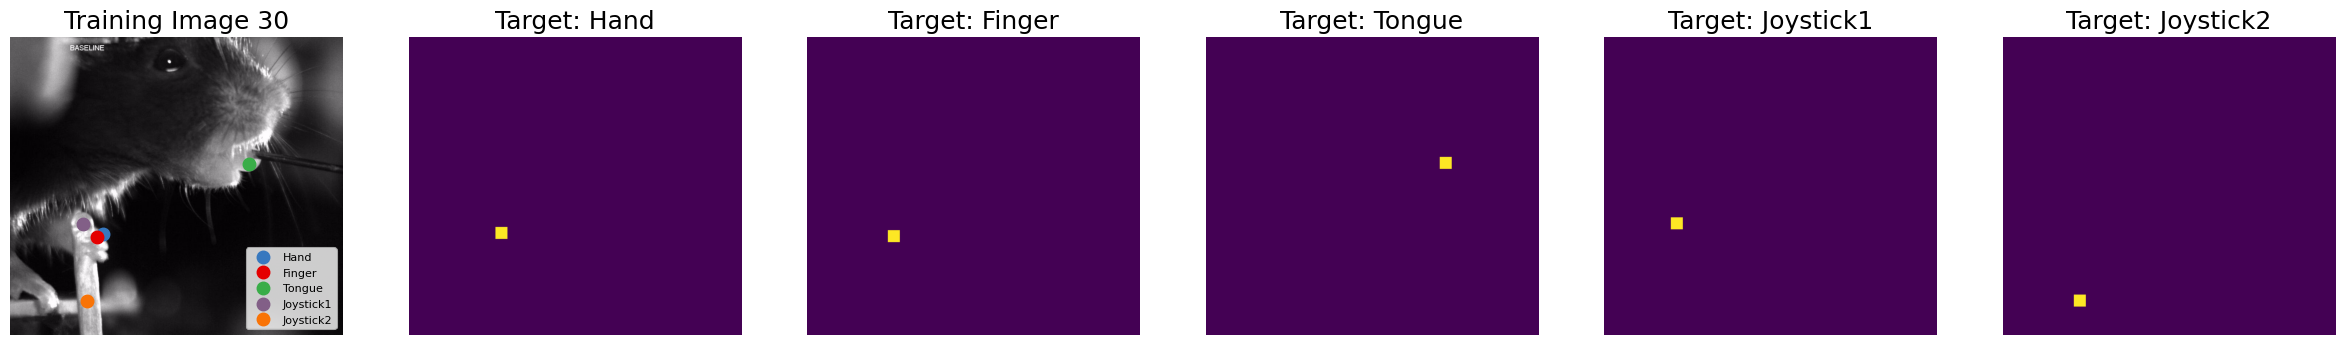

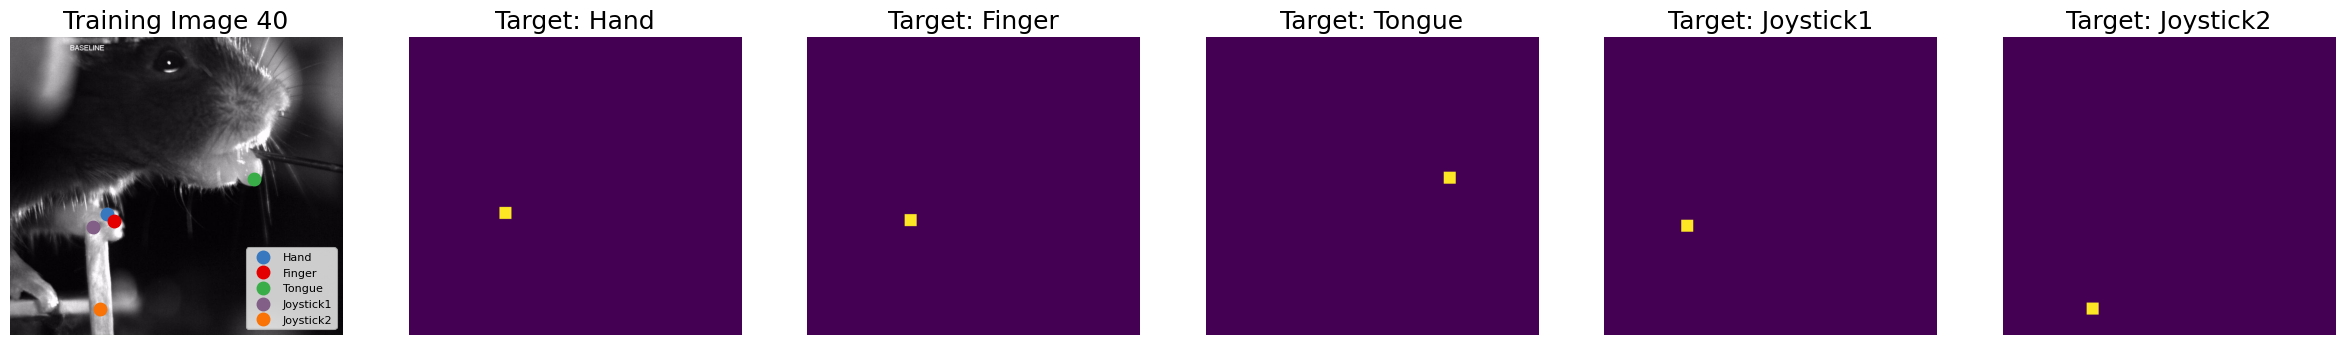

In [6]:
for index in [0, 10, 20, 30, 40]:
    plot_example(train_images[index],
                 train_coords[index],
                 train_targets[index],
                 dilation=30,
                 title="Training Image {}".format(index))

### Play the test movie

We'll test the models on this 8 second clip of the mouse reaching for a joystick and licking a spout. Here, all the frames are ordered and the same size, so it makes sense to show a movie.

In [ ]:
play(test_images)

Preparing animation. This may take a minute...


## Part 1: Groundwork for fitting models

Before writing the PyTorch models, let's first lay some groundwork for model fitting and evaluation. One of the nice features of PyTorch is its data loading framework. We'll first write a `Dataset` class for loading and preprocessing the keypoint data. Then we'll write a generic function for training models via stochastic gradient descent. These will come in handy in Parts 2 and 3 of the lab.




### Make a PyTorch Dataset class for keypoint data

We follow the [PyTorch data loading tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to make a `Dataset` object for this data. As the comments below say, the dataset is a lightweight wrapper that implements the `iterable` interface. It has a `__getitem__` function that returns requested datapoints (typically we request just one at a time).  Each datapoint is packaged into a dictionary with an `image` key and a `targets` key, which contain $\mathbf{X}_n$ and $\mathbf{Y}_n$ in the notation above.

Notes:
- Before transformation, $\mathbf{X}_n$ is actually shape `(P_H, P_W, 3)`, where 3 is the RGB color axis.
- The getter applies a given list of transformations, one of which will permute the order of the axes so that the color channel comes first.

In [7]:
class KeypointDataset(Dataset):
    """Dataset of keypoints in the DeepLabCut (DLC) format."""
    def __init__(self,
                 images: List[Int[Tensor, "height width 3"]],
                 targets: Optional[List[Bool[Tensor, "num_keypoints height width"]]] = None,
                 transforms: Optional[List[Any]] = []):
        """
        A PyTorch dataset is a lightweight wrapper for an iterable
        dataset. It exposes a __getitem__ function that returns an
        example at the specified index (or a set of examples if a
        list of indices is requested). Here, each example will be
        a dictionary with an `image` key and a `target` key. The
        getter will optionally apply a sequence of transformations
        to each example. More on this below.

        images: list (or iterable) of arrays, each H_n x W_n x 3
            where 3 denotes the number of color channels (RGB).
            The arrays must be type uint8 (values 0...255).

        targets: [optional] list (or iterable) of arrays, each
            K x H_n x W_n where K denotes the number of keypoints.
            Each H_n x W_n slice should be a one hot matrix indicating
            the location of the corresponding keypoint.

        transforms: [optional] list (or iterable) of Transform objects
            to call before returning an example. See below.
        """
        # convert uint8 images (values 0...255) to float32
        assert all([im.dtype == torch.uint8 for im in images]), \
            "Expected images to be uint8's."
        self.images = [im.type(torch.float32) / 256 for im in images]

        # Check that the targets are the right size and shape
        self.targets = targets
        if targets is not None:
            assert len(targets) == len(images)
            assert all([tgt.shape[0] == num_keypoints for tgt in targets])
            assert all([img.shape[:2] == tgt.shape[-2:]
                        for img, tgt in zip(images, targets)])

        # Store any transforms that the user requests
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: Union[int, Tensor]
                    ) -> dict[str, Tensor]:
        # Convert indices to list if necessary
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Pull out specified images
        image = self.images[idx]

        # Extract the keypoints if present, o/w return -1
        if self.targets is not None:
            targets = self.targets[idx]
        else:
            targets = -1 * torch.ones_like(torch.tensor(idx))

        # Package output into a dictionary
        datapoint = dict(image=image, targets=targets)

        # Apply the specified transforms
        for transform in self.transforms:
            datapoint = transform(datapoint)

        return datapoint

### Define transformations to apply to each datapoint

As you see above, the getter in the `KeypointDataset` object can apply a sequence of transformations. Here we'll define four such transformations. Each is an object with a `__call__` function, which takes as input a datapoint and outputs a transformed datapoint. As above, the datapoints are dictionaries with an `image` key and a `targets` key.

We'll implement the first two transformations for you, so you can see how they work. The first two are:
1. Transpose the `image` axes to be channels x height x width, as expected by PyTorch, and then move `image` and `targets` to `device` (GPU if available).
2. Normalize the color channels of the image so that they have the mean and standard deviation expected by pretrained PyTorch models.

You'll implement two more transformations below.

In [8]:
class TransposeAndMove(object):
    """Convert ndarrays in sample to Tensors on the GPU."""
    def __call__(self,
                 datapoint: Dict[str, Union[Tensor, Float[Tensor, "height width 3"]]]
                 ) -> Dict[str, Union[Tensor, Float[Tensor, "3 height width"]]]:
        # swap image color axis because
        # numpy image: H x W x 3
        # torch image: 3 X H X W
        image = datapoint['image'].permute((2, 0, 1))
        targets = datapoint['targets'].type(torch.float32)
        return dict(image=image.to(device),
                    targets=targets.to(device))


class Normalize(object):
    """Normalize the images to have the mean and standard deviation
    expected by pretrained pytorch models.

    See: https://pytorch.org/docs/stable/torchvision/models.html
    """
    def __call__(self,
                 datapoint: Dict[str, Tensor]
                 ) -> Dict[str, Tensor]:
        image = torchvision.transforms.functional.normalize(
            datapoint['image'],
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
        return dict(image=image, targets=datapoint['targets'])


### Problem 1a: Implement a Downsampling transformation

Write a transformation object called `Downsample` that downsamples the image and target by a specified factor. This will make our code run faster, albeit with slightly lower precision.

You may need to consult the documentation in [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html), which is imported as `F` below.

In [9]:
class Downsample(object):
    """Downsample the image using avg_pool2d
    and the target (if given) with max_pool2d."""
    def __init__(self,
                 downsample_factor: int = 1):
        self.downsample_factor = downsample_factor

    def __call__(self,
                 datapoint: Dict[str, Union[Float[Tensor, "3 height width"], Float[Tensor, "num_keypoints height width"]]]
                 ) -> Dict[str, Tensor]:
        """
        Downsample the image and (if present) the targets
        by `self.downsample_factor`.

        datapoint: dict with keys `image` and `targets`.
            Assume both are PyTorch tensors and their shapes
            are (3, H, W) and (K, H, W), respectively.
        """
        image = datapoint['image']

        ###
        # Downsample image by a factor of `self.downsample_factor`
        # using `F.avg_pool2d
        #
        # YOUR CODE BELOW
        image = F.avg_pool2d(image, self.downsample_factor)

        # Downsample targets by max pooling, if present.
        # (If no targets are given, they will be a 1d array of -1's.)
        targets = datapoint['targets']
        if targets.ndim > 1:
            targets = F.max_pool2d(targets, self.downsample_factor)
        ###

        return dict(image=image, targets=targets)

# Test by comparing to manual downsampling.
def test_downsample():
    dummy_image = np.arange(300).reshape(3, 10, 10)
    dummy_image_ds = dummy_image.reshape(3, 5, 2, 5, 2).mean(axis=(2, 4))

    dummy_target = np.zeros((5, 10, 10))
    dummy_target[0, 4, 4] = 1
    dummy_target[1, 5, 5] = 1
    dummy_target[2, 6, 6] = 1
    dummy_target[3, 7, 7] = 1
    dummy_target[4, 8, 8] = 1
    dummy_target_ds = dummy_target.reshape(5, 5, 2, 5, 2).max(axis=(2, 4))

    dummy_datapoint = dict(image=to_t(dummy_image), targets=to_t(dummy_target))
    dummy_output = Downsample(2)(dummy_datapoint)
    assert from_t(dummy_output['image']).shape == dummy_image_ds.shape
    assert np.allclose(from_t(dummy_output['image']), dummy_image_ds, atol=1e-4)
    assert from_t(dummy_output['targets']).shape == dummy_target_ds.shape
    assert np.allclose(from_t(dummy_output['targets']), dummy_target_ds, atol=1e-4)

test_downsample()

### Problem 1b: Implement a transformation to dilate the targets

Dilate the targets to make them a bit bigger. This offers more positive examples for our model.

In [20]:
class DilateTargets(object):
    """Dilate the binary target by convolving with ones."""
    def __init__(self,
                 dilation_factor: int = 1):
        self.dilation_factor = dilation_factor
        assert dilation_factor % 2 == 1, "dilation_factor must be odd"

    def __call__(self,
                 datapoint: Dict[str, Union[Float[Tensor, "3 height width"], Float[Tensor, "num_keypoints height width"]]]
                 ) -> Dict[str, Tensor]:
        """
        Dilate the target by a factor of `self.dilation_factor`
        by convolving by a square matrix of ones of that size.

        datapoint: dict with keys `image` and `targets`.
            Assume both are PyTorch tensors and their shapes
            are (3, H, W) and (K, H, W), respectively.
        """
        targets = datapoint['targets']
        shape = targets.shape
        assert targets.ndim > 1, "DilateTargets called without targets!"

        ###
        # Convolve each keypoint (input channel) with a square of ones.
        # Pad the convolution so that the output is the same shape as the
        # input and the center of the dilated targets are on the ones in
        # the original targets.
        #
        # Hint: you may find the `groups` keyword argument of conv2d helpful.
        #
        # YOUR CODE BELOW

        #Modify targets to have batch dimension at targets[0] = 1
        targets = targets.unsqueeze(0)

        #Initialize Kernel
        weights = torch.ones(targets.shape[1], 1, self.dilation_factor, self.dilation_factor)
        weights = weights.to(targets.device)

        targets = F.conv2d(targets, weights, stride = 1, padding = (self.dilation_factor //2 ), groups = targets.shape[1])
        targets = targets.squeeze(0)

        ###

        assert targets.shape == shape
        return dict(image=datapoint['image'], targets=targets)

#  Test by comparing to dilation with scipy.ndimage.
def test_dilate():
    from scipy.ndimage import binary_dilation
    dummy_target = np.zeros((5, 10, 10))
    dummy_target[0, 4, 4] = 1
    dummy_target[1, 5, 5] = 1
    dummy_target[2, 6, 6] = 1
    dummy_target[3, 7, 7] = 1
    dummy_target[4, 8, 8] = 1
    dummy_target_dil = np.array(
        [binary_dilation(tgt, structure=np.ones((3, 3)))
        for tgt in dummy_target])
    dummy_datapoint = dict(image=None, targets=to_t(dummy_target))
    dummy_output = DilateTargets(3)(dummy_datapoint)

    assert from_t(dummy_output['targets']).shape == dummy_target_dil.shape
    assert np.allclose(from_t(dummy_output['targets']), dummy_target_dil, atol=1e-4)

test_dilate()

### Problem 1c: Initialize datasets for the training, validation, and test data

Make `KeypointDataset` objects for the training, validation, and test data. In all cases, apply the following (ordered) set of transformations:
1. Convert the tensors and move them to `device` with `Transpose`
2. Normalize the color channels with `Normalize`
3. Downsample the images (and targets) by a factor of 2 with `Downsample`. This will speed up all your analyses at the cost of a little lower resolution.

Finally, for the training and validation data only:
4. Apply `DilateTargets` with a dilation factor of 21 (equivalent to dilating by 42 pixels in the original image).

In [22]:
###
# Make the training, validation, and test datasets as described aboe.
#
# YOUR CODE BELOW
downsample = 2
dilate = 21
train_dataset =
train_dataset = KeypointDataset(train_images, [TransposeAndMove, Normalize, Downsample(downsample), DilateTargets(dilate)])
val_dataset =
test_dataset = ...
###

#Plot the training examples from above but after transformation
for index in [0, 10, 20, 30, 40]:
    plot_example(from_t(train_dataset[index]['image'][0]),
                train_coords[index],
                from_t(train_dataset[index]['targets']),
                downsample=downsample,
                title="Train Image {}".format(index))

# Test
assert train_dataset[0]['image'].shape == (3, 373, 416)
assert train_dataset[0]['targets'].shape == (5, 373, 416)
assert train_dataset[0]['targets'].sum() == 1764
assert val_dataset[0]['image'].shape == (3, 235, 320)
assert val_dataset[0]['targets'].shape == (5, 235, 320)
assert val_dataset[0]['targets'].sum() == 1764
assert test_dataset[0]['image'].shape == (3, 373, 416)
assert test_dataset[0]['targets'] == -1

AssertionError: 

### Problem 1d: Comment this function for training Pytorch models

We've written a generic model training function following [this example](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

**The code is written. You just have to write comments for this function.**

In [ ]:
def train_model(model: nn.Module,
                train_dataset: Dataset,
                val_dataset: Dataset,
                criterion: Callable[[Tensor, Tensor], Tensor],
                num_epochs: int = 200,
                lr: float = 1.0,
                momentum: float = 0.9,
                lr_step_size: int = 100,
                lr_gamma: float = 0.1) -> Tuple[List[float], List[float]]:
    pbar = trange(num_epochs)
    pbar.set_description("---")

    train_dataloader = DataLoader(train_dataset, batch_size=1)
    val_dataloader = DataLoader(val_dataset, batch_size=1)
    dataloaders = dict(train=train_dataloader, val=val_dataloader)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_step_size,
                                    gamma=lr_gamma)

    train_losses = []
    val_losses = []
    for epoch in pbar:

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0
            running_size = 0
            for datapoint in dataloaders[phase]:
                image = datapoint['image']
                targets = datapoint['targets']
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()
                        output = model(image)
                        loss = criterion(output, targets)
                        loss.backward()
                        optimizer.step()
                else:
                    output = model(image)
                    loss = criterion(output, targets)

                assert loss >= 0
                running_loss += loss.item()
                running_size += 1

            running_loss /= running_size
            losses = train_losses if phase == "train" else val_losses
            losses.append(running_loss)

        scheduler.step()

        pbar.set_description("Epoch {:03} Train {:.4f} Val {:.4f}"\
                             .format(epoch, train_losses[-1], val_losses[-1]))
        pbar.update(1)

    return train_losses, val_losses

## Part 2: Implement basic pose tracking with a CNN

Our "basic model" will use a CNN to implement a template matching/logistic regression model.

First, notation: let
- $\mathbf{X}_n \in \mathbb{R}^{P_H \times P_W}$ denote the a (lightly preprocessed) input image. Its height is $P_H$ pixels and its width is $P_W$ pixels.
- $\mathbf{Y}_{n,k} \in \{0,1\}^{P_H \times P_W}$ denote the binary target for keypoint $k$.
- $\mathbf{W}_k \in \mathbb{R}^{P_h \times P_w}$ denote the template (i.e. *weights*) for keypoint $k$. It is $P_h < P_H$ by $P_w < P_W$ pixels.
- $b_k \in \mathbb{R}$ denote a bias for keypoint $k$.


The "basic" model treats keypoint estimation as a logistic regression problem. We convolve the image with weights to obtain the log-odds (aka *logits*) of keypoint $k$ for image $n$,

$$
\mathbf{A}_{n,k} = (\mathbf{X}_n \star \mathbf{W}_k) + b_k.
$$

Note that $\mathbf{A}_{n,k}  \in \mathbb{R}^{P_H \times P_W}$ is the same shape as the input image.  Its entries specify the log-odds of keypoint $k$ being found at each pixel.
Finally, map the logits through a logistic function to get probabilities, and plug them into the Bernoulli likelihood function,

$$
p(\mathbf{Y}_{n,k} \mid \mathbf{X}_n, \mathbf{W}_k, b_k) = \prod_{i=1}^{P_H} \prod_{j=1}^{P_W} \mathrm{Bern}(y_{nkij} \mid \sigma(a_{nkij})).
$$

We'll maximize the (log) likelihood of a image as a function of $\mathbf{W}_k, b_k$,

$$
\begin{aligned}
\mathcal{L}(\mathbf{W}_k, b_k) &= \sum_{n=1}^N \sum_{i=1}^{P_H} \sum_{j=1}^{P_W} \log \mathrm{Bern}(y_{nkij} \mid \sigma(a_{nkij})) \\
&= \sum_{n=1}^N \sum_{i=1}^{P_H} \sum_{j=1}^{P_W} y_{nkij} a_{nkij} - \log (1 + \exp \{a_{nkij}\})
\end{aligned}
$$

as we derived in class.

In practice, we'll actually minimize the negative average log likelihood via stochastic gradient descent by grabbing one image at a time, evaluating the loss function for that image, taking the gradient of the loss (automatically), and updating our weights by taking a step in the direction of the gradient.

**Practicalities.**
A few practical issues should be mentioned:
- To speed training and gain some statistical efficiency, our basic model will downsample the images before applying the convolution and then upsample the logits to the full resolution before evaluating the loss. You can think of this as a form of weight sharing.
- Likewise, our basic model will operate on grayscale images by taking the mean over the color channels.


### Problem 2a: Implement the basic model

A PyTorch model inherits from `nn.Module`. It has trainable parameters, which are encapsulated in its class variables. For example, the `BasicPoseTracker` model below has a `self.final_conv` class variable, which is an instance of `nn.Conv2d`, an object that implements a 2D convolution. (We've said this before, but remember convolutions in deep learning are cross-correlations in the real world.) The `Conv2d` object has inside of it a set of parameters, which the training algorithm above will modify, in place, via stochastic gradient descent. In particular, the `Conv2d` object has a stack of weights and a set of biases, one for each keypoint.

PyTorch models implement a `forward` function, which takes an input and produces an output. Here, the input is a batch of images `B x 3 x P_H x P_W`, but really the batch will just be shape `1` since different images may be different sizes. The output will be a `B x K x P_H x P_W` set of log-odds, or "logits," one for each image, keypoint, and pixel.

In the basic model, the `foward` function should perform the following operations:
1. Convert the image to grayscale by taking the mean over the color axis to produce a `B x 1 x P_H x P_W` output.
2. Downsample by the downsampling factor specified in the constructor. We'll allow fractional downsampling, which is best implemented with the `F.interpolate` function.
3. Apply the convolution to the downsampled image to get logits for each keypoint.
4. Upsample the logits back to the original image size, again using `F.interpolate`.

The forward function returns the upsampled logits.

In [ ]:
class BasicPoseTracker(nn.Module):
    def __init__(self,
                 num_keypoints: int,
                 downsample: int = 1,
                 patch_size: int = 121):
        super(BasicPoseTracker, self).__init__()
        self.num_keypoints = num_keypoints
        assert downsample >= 1.0, "downsample factor must be at least 1"
        self.downsample = downsample
        self.patch_size = patch_size

        # compute the effective patch size in the downsampled image
        # round to the nearest odd number so that the convolution is centered.
        self.eff_patch_size = to_odd(patch_size / downsample)

        ###
        # Convolve (in neural net lingo; cross-correlate in stats lingo)
        # the input with a stack of weights. The weights are parameters of
        # the nn.Conv2d layer, initialized below. Its dimensions are 1 (the
        # number of input channels) by K (the number of keypoints) by H by W
        # (the height and width of the patch). Pad the input with (H // 2) and
        # (W // 2) zeros so that the output is the same size as the input.
        # Note that by default the convolution layer also has a learnable bias,
        # which we want.
        #
        # YOUR CODE BELOW
        self.final_conv = nn.Conv2d(...)
        ###

    def forward(self,
                x: Float[Tensor, "1 3 height width"]
                ) -> Float[Tensor, "1 num_keypoints heigth width"]:
        """
        Run the "forward pass" of the model to produce logits for
        a batch of images `x`.

        x: (1 x 3 x H x W) "batch" of images, where the batch size
           is always 1.

        returns: (1 x K x H x W) batch of logits for each keypoint.
        """
        original_size = x.shape[-2:]

        ###
        # Complete the steps below, which iteratively update
        # `x` by applying a sequence of functions to it.
        #
        # YOUR CODE BELOW

        # 1. Convert to grayscale by taking a mean over
        #    the color channels (axis=1).
        x = ...

        # 2. Further downsample the image by the factor specified above.
        #    Catch warnings in the F.interpolate function.
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            x = F.interpolate(...)

        # 3. Apply your convolution layer
        x = ...

        # 4. Interpolate back to the original size
        #    Catch warnings in the interpolate function.
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            x = F.interpolate(...)
        ###

        return x


### Instantiate the model and move it to `device`
Fix the random seed so the weights will be reproducible.

In [ ]:
# Construct a basic pose tracker with random initial weights.
torch.manual_seed(0)
basic_model = BasicPoseTracker(num_keypoints,
                               downsample=4,
                               patch_size=101)

# Move the model to device (GPU if available)
basic_model = basic_model.to(device)

### Problem 2b: Plot model predictions

Write a function to compute the keypoint probabilities output by the model.

Since the constructor initialized the `Conv2d` layer with random weights, the initial predictions should be terrible.

In [ ]:
def plot_model_predictions(model: nn.Module,
                           datapoint: Dict[str, Tensor]):
    """Plot the image and the model's predictions
    (i.e. probabilities per pixel) for each of the
    keypoints.
    """
    image = datapoint['image']

    ###
    # Compute the model probabilities $\sigma(A)$.
    # It should be a K x H x W array.
    #
    # YOUR CODE BELOW
    probs = ...
    ###


    assert probs.shape[0] == num_keypoints
    assert probs.shape[1:] == image.shape[1:]
    plot_image_and_probs(from_t(image), from_t(probs))

# Plot the probabilities output under the initial, random parameters
plot_model_predictions(basic_model, train_dataset[0])

### Problem 2c [Math] Log-sum-exp trick
The log likelihood contains terms of the form,

$$
\log (1 + e^a)
$$

Show that this is equivalent to,

$$
m + \log (e^{-m} + e^{a - m})
$$

for any $m \in \mathbb{R}$.

Set $m = \max \{0, a\}$. Why does this lead to a more numerically stable computation?



---

_Your answer here_


### Problem 2d: Implement the Bernoulli loss
Implement the `bernoulli_loss` function below. It should return the average negative log likelihood over all keypoints and pixels. I.e.

$$
-\frac{1}{K P_H P_W} \sum_{k=1}^K \mathcal{L}(\mathbf{W}_k, b_k).
$$

Use the log-sum-exp trick derived above to implement this function.

_Note: PyTorch implements this loss function as `F.binary_cross_entropy_with_logits`. You may use that function to check your answers, but in this problem we want you to implement the calculation from scratch._

In [ ]:
def bernoulli_loss(logits: Float[Tensor, "num_keypoints height width"],
                   targets: Bool[Tensor, "num_keypoints height width"]
                   ) -> Float:
    """Compute the Bernoulli loss for a single image in the comment above.

    logits:  K x P_H x P_W array of logits ($a_{kij}$)
    targets: K x P_H x P_W array of binary targets ($y_{kij}$)

    returns: scalar average negative log likelihood.
    """
    ###
    # Compute the average negative log likelihood.
    #
    # YOUR CODE BELOW
    avg_nll = ...
    ###

    return avg_nll


# Test on a single image
image = train_dataset[0]['image']
logits = basic_model(image.unsqueeze(0)).squeeze(0)
targets = train_dataset[0]['targets']
assert torch.isclose(bernoulli_loss(logits, targets),
                     torch.tensor(0.9426), atol=1e-4)

# Test that it works even with potential overflow
logits = 1e3 * torch.ones_like(targets)
assert torch.isfinite(bernoulli_loss(logits, targets))

### Train the basic model

Note: This should take around 2 minutes on a Colab T4 GPU.

In [ ]:
# Train the basic model
train_losses, val_losses = train_model(basic_model,
                                       train_dataset,
                                       val_dataset,
                                       bernoulli_loss)

# Plot the training and validation curves
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_losses, color=palette[0], label="train")
axs[0].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("bernoulli loss")
axs[0].set_ylim(bottom=0)
axs[0].grid(True)

axs[1].plot(train_losses, color=palette[0], label="train")
axs[1].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("bernoulli loss")
axs[1].set_ylim(0, val_losses[50])
axs[1].grid(True)
axs[1].legend(loc="upper right")

plt.tight_layout()

### Look at model outputs

Try the model on the same training image as above. If it's working, you should see the keypoint probabilities are close to one (yellow) at the keypoint and zero (blue) elsewhere.




In [ ]:
plot_model_predictions(basic_model, train_dataset[0])

Now plot the inferred weights. These are the $\mathbf{W}_k$'s that the logistic regression convolves with the images.

In [ ]:
plot_model_weights(basic_model)

### Problem 2e [Short Answer]: Interpret the inferred weights

The probabilities are derived from the learned weights, plotted above. Are they interpretable and/or expected?

---

_Your answer here_

### Make a movie of the predictions on the test data

In [ ]:
# Extract probabilities for each frame
basic_probs = []
for t in trange(len(test_dataset)):
    ex = test_dataset[t]
    logits = basic_model(ex["image"].unsqueeze(0)).squeeze(0)
    basic_probs.append(torch.sigmoid(logits))
basic_probs = torch.stack(basic_probs).detach().to('cpu')

play_overlay(test_images, basic_probs, prob_clip=0.5)

## Part 3: Transfer learning from a pretrained ResNet

Now we'll download a pretrained residual network from PyTorch's model zoo and hijack its intermediate layer features to predict keypoint locations.  This is called **transfer learning**: using a model trained for a different purpose (here, image classification) as the basis for a new task (here, keypoint detection).


In [ ]:
# Download a pretrained resnet50 from pytorch's model zoo and copy it to the device
pretrained_resnet50 = models.resnet50(weights="IMAGENET1K_V1").to(device)

The ResNet source code can be found [here](https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html). Its `forward` function applies the following layers, with my comments added:
```    
def _forward_impl(self, x):
    # See note [TorchScript super()]
    x = self.conv1(x)         # 2d convolution over color channels
    x = self.bn1(x)           # batch norm
    x = self.relu(x)          # nonlinearity
    x = self.maxpool(x)       # max pooling

                              # Now for the residual network!
                              # Each "layer" is a series of strided convolutions,
                              # batch normalization, and nonlinearities. The
                              # result is added to the (downsampled) input
                              # before passing through the final nonlinearity to
                              # produce an output with the specified number of
                              # channels (planes) and downsampling factors.

    x = self.layer1(x)        # outputs 256  channels @ 4x   downsampling
    x = self.layer2(x)        # outputs 512  channels @ 8x   downsampling
    x = self.layer3(x)        # outputs 1024 channels @ 16x  downsampling
    x = self.layer4(x)        # outputs 2048 channels @ 32x  downsampling

    x = self.avgpool(x)       # adaptive average pooling over pixels to get a 2048x1x1 output
    x = torch.flatten(x, 1)   # flatten to remove trailing dimensions
    x = self.fc(x)            # pass through a fully connected layer to make final predictions!

    return x

def forward(self, x):
    return self._forward_impl(x)
```

We'll write our own torch `Module` that freezes the weights of the pretrained ResNet and then learns to predict binary presence or absence of a keypoint at each pixel.

### Problem 3a: Implement the resnet model

In [ ]:
init_layer_names = ['conv1', 'bn1', 'relu', 'maxpool']
bottleneck_layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
bottleneck_sizes = [256, 512, 1024, 2048]

class ResnetPoseTracker(nn.Module):
    def __init__(self,
                 resnet: nn.Module,
                 num_keypoints: int,
                 num_bottleneck_layers: int,
                 kernel_size: int):
        """A pose tracking model that uses a pretrained resnet to extract
        features.

        resnet: the pretrained resnet model

        num_keypoints: the number of keypoints to predict

        num_bottleneck_layers: the number of bottleneck layers to apply
            before extracting features. Must be 1, 2, 3, or 4.

        kernel_size: the size of the kernel in the final convolutional
            layer. Equivalently, the number of "super pixels" to use in
            making the final keypoint probability predictions. This is
            analogous to the patch size in the basic model.
        """
        super(ResnetPoseTracker, self).__init__()

        # Copy the specified layers from the pretrained resnet
        # and fix their parameters by setting `requires_grad = False`
        # If `setattr` and `getattr` are unfamiliar, take a minute
        # to google them and understand what we're doing here.
        for layer_name in init_layer_names + bottleneck_layer_names:
            setattr(self, layer_name, deepcopy(getattr(resnet, layer_name)))
            for param in getattr(self, layer_name).parameters():
                param.requires_grad = False

        # Store the number of bottleneck layers
        assert num_bottleneck_layers >= 1 and num_bottleneck_layers <= 4
        self.num_bottleneck_layers = num_bottleneck_layers

        # Add a final conv layer applied across channels for each "super pixel".
        # The number of input channels is determined by the output of the last
        # bottleneck layer applied. There is an output channel for each keypoint
        # and a kernel of specified size. Make sure you pad the convolution so
        # the  output size is the same as the input size.
        assert kernel_size % 2 == 1
        self.final_conv = nn.Conv2d(
            bottleneck_sizes[num_bottleneck_layers - 1],
            num_keypoints,
            kernel_size=kernel_size,
            padding=kernel_size // 2)

    def forward(self,
                x: Float[Tensor, "1 3 height width"]
                ) -> Float[Tensor, "1 num_keypoints heigth width"]:
        original_size = x.shape[-2:]

        ###
        # Implement the forward pass. Apply all the initial layers but only the
        # specified number of bottleneck layers. Then apply your final
        # convolution layer and interpolate to get logits the same size as the
        # input image.
        #
        # YOUR CODE BELOW
        ...
        ###
        assert x.shape[-2:] == original_size
        return x

### Instantiate the resnet model

In [ ]:
# Initialize the resnet pose model
torch.manual_seed(0)
resnet_model = ResnetPoseTracker(pretrained_resnet50,
                                 num_keypoints,
                                 num_bottleneck_layers=1,
                                 kernel_size=3).to(device)

# Plot the model predictions
plot_model_predictions(resnet_model, train_dataset[0])

### Problem 3b: Plot the resnet features after each bottleneck layer

First, write a function to compute the model predictions after a specified number of bottleneck layers. Then plot a few of the features for each layer.

In [ ]:
def get_features(resnet_model: nn.Module,
                 datapoint: dict[str, Tensor],
                 num_layers: int
                 ) -> Tensor:
    """
    Get the pretrained resnet features at the specified
    bottleneck layer.

    image: (3 x H x W) input image tensor from dataset
    bottleneck_layer: number 1...4 specifying with layer to output
    """
    assert num_layers >= 1 and num_layers <= 4
    image = datapoint["image"]

    ###
    # Run the image through the resnet up to the output of
    # the specified bottleneck layer. Eg. if num_layers == 1,
    # give the output after resnet.layer1
    #
    # YOUR CODE BELOW
    x = ...
    ###
    return x

for num_layers, layer_size in enumerate(bottleneck_sizes):
    features = get_features(resnet_model, train_dataset[0], num_layers+1)
    assert features.shape[0] == layer_size

    # Plot the first four feature channels
    num_features = 5
    fig, axs = plt.subplots(1, num_features,
                            figsize=(4 * num_features, num_features),
                            sharey=True)
    for i, ax in enumerate(axs):
        ax.imshow(from_t(features[i]), cmap="Greys_r")
        ax.set_title("layer {} feature {}/{}".format(num_layers+1, i, layer_size))

### Problem 3c [Short Answer]: Discuss the pros/cons of number of layers

When predicting keypoints, we could take the output of the model after any one of the layers. Discuss the considerations the pros and cons of deeper vs shallower layers.

---

_Your answer here_


### Train the resnet model

In [ ]:
train_losses, val_losses = train_model(resnet_model,
                                       train_dataset,
                                       val_dataset,
                                       bernoulli_loss)

# Plot the training and validation curves
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_losses, color=palette[0], label="train")
axs[0].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("bernoulli loss")
axs[0].set_ylim(bottom=0)
axs[0].grid(True)

axs[1].plot(train_losses, color=palette[0], label="train")
axs[1].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("bernoulli loss")
axs[1].set_ylim(0, val_losses[50])
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()

### Plot the resnet predictions

In [ ]:
plot_model_predictions(resnet_model, train_dataset[0])

### Make a movie of the predictions on test data

In [ ]:
# Extract probabilities for each frame
resnet_probs = []
for t in trange(len(test_dataset)):
    ex = test_dataset[t]
    logits = resnet_model(ex["image"].unsqueeze(0)).squeeze(0)
    resnet_probs.append(torch.sigmoid(logits))
resnet_probs = torch.stack(resnet_probs).detach().to("cpu")

play_overlay(test_images, resnet_probs, prob_clip=0.5)

## Part 4: Model comparison


### Problem 4a: Grid search
So far, you've trained models for only one set of hyperparameters. In practice, you would perofrm a grid search over these hyperparameters to see if you can find better settings.

You could optimize many hyperparameters, but for this problem, you'll focus on just one hyperparameter per model"

For the **basic model** (from Part 2), fix the `patch_size` to 51 (a bit smaller than used above) and sweep over the `downsampling` factor. Plot the validation loss as a function of the `downsampling` factor.

For the **Resnet model** (from Part 3), fix the `kernel_size` to 3 and sweep over `num_bottleneck_layers`. Plot the validation loss as a function of `num_bottle_layers`.

In general, you won't necessarily know the ideal range of these parameters. We leave it up to you to determine the appropriate range of values for the grid search.

In [ ]:
### YOUR CODE HERE

### Problem 4b [Short Answer]: Discussion

Summarize your results and discuss their implications. In your discussion, address the following prompts:

- Was there anything surprising about your results?
- What changes could you consider to further improve your results?
- How could you combine the predicted probabilities into a consistent estimate of all $K$ key point locations?


---

_Your answer here_
